In [37]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import tifffile as tiff
import cv2

Read in the tiff stack and remove dims 56-59:

In [67]:
FILEPATH = "/home/omar/projects/unc/PHASER/data/phaser_rpe/raw/images/cell_0001.tif"

tiff_stack = tiff.imread(FILEPATH)
tiff_tensor = torch.tensor(tiff_stack)

# Take out non-nucleous masks
tiff_tensor = torch.cat((tiff_tensor[:55], tiff_tensor[57:]), dim=0)
tiff_tensor = torch.tensor(tiff_tensor / 255)
tiff_tensor.shape

/tmp/ipykernel_41908/3708557709.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tiff_tensor = torch.tensor(tiff_tensor / 255)


torch.Size([57, 100, 100])

Extract the masks:

In [68]:
nuc_mask = tiff_tensor[55].bool()
ring_mask = tiff_tensor[56].bool()
combined_mask = torch.logical_or(nuc_mask, ring_mask)
type(combined_mask)

torch.Tensor

Now to plot them:

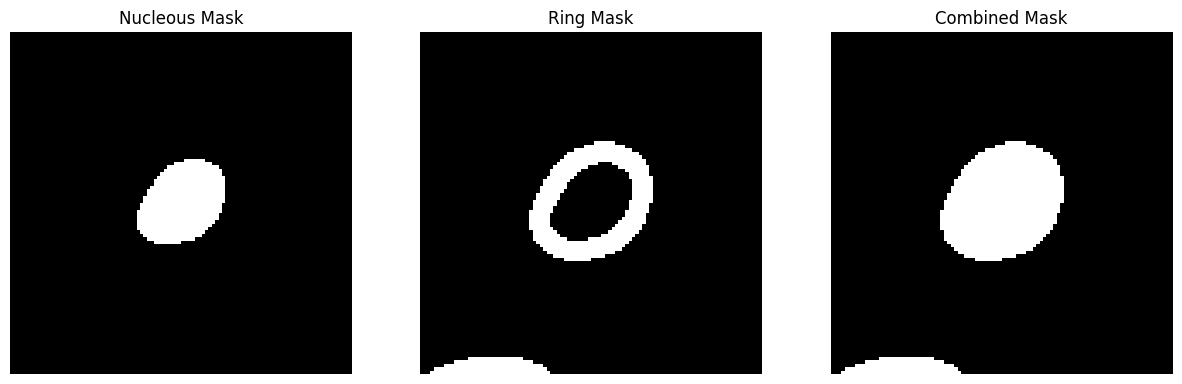

In [69]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
masks = [nuc_mask, ring_mask, combined_mask]
titles = ["Nucleous Mask", "Ring Mask", "Combined Mask"]

for ax, mask, title in zip(axes, masks, titles):
    ax.imshow(mask, cmap="gray")
    ax.set_title(title)
    ax.axis("off")
    
plt.show()

Now, we need to only get the mask in the center of the image. 

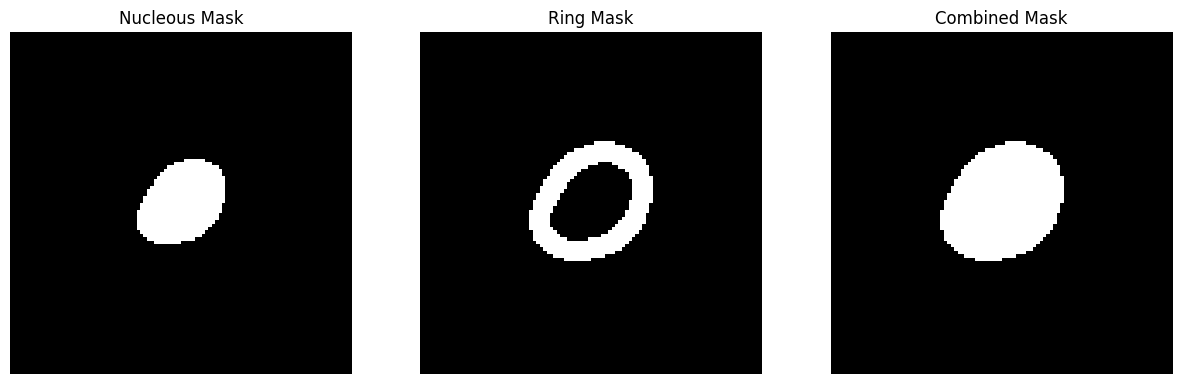

In [70]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, mask, title in zip(axes, masks, titles):
    mask_unit8 = mask.numpy().astype(np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_unit8)
    img_center = np.array(mask.shape) // 2
    
    distances = np.linalg.norm(centroids - img_center, axis=1)
    closest_label = np.argmin(distances[1:]) + 1
    center_mask = (labels == closest_label).astype(np.uint8)
    center_mask = torch.tensor(center_mask)
    
    ax.imshow(center_mask, cmap="gray")
    ax.set_title(title)
    ax.axis("off")
    
plt.show()

Show example before and after masking:

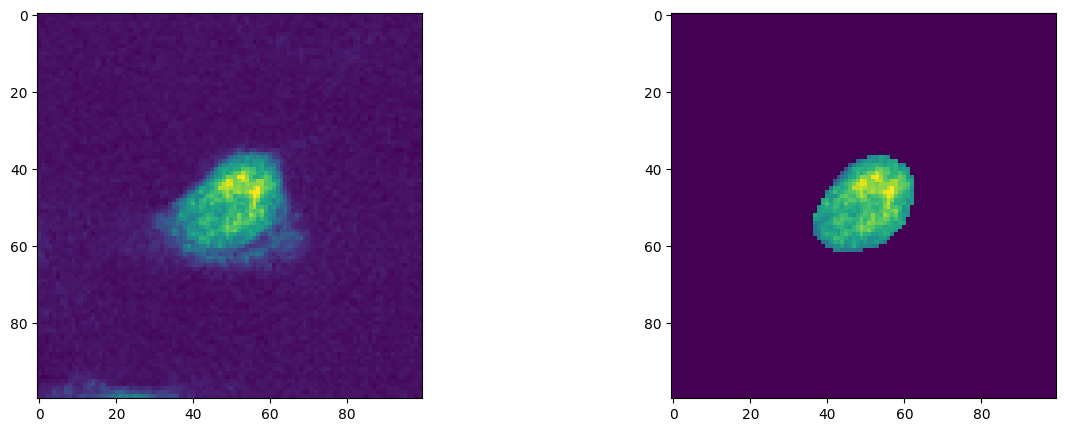

In [88]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].imshow(tiff_tensor[10])

tiff_masked = tiff_tensor * masks[0]
axes[1].imshow(tiff_masked[10])
plt.show()

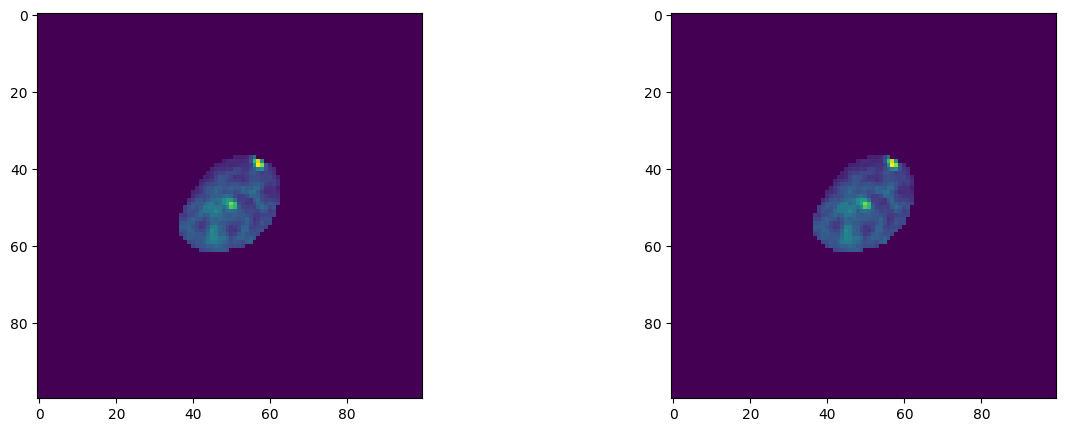

In [92]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
extra_dims_removed = tiff_masked[:55]
axes[0].imshow(tiff_masked[54])
axes[1].imshow(extra_dims_removed[54])
plt.show()

